In [ ]:
from pathlib import Path
from functools import partial
import datetime as dt
import calendar
import xarray as xr
import multiprocessing as mp
import numpy as np
import pandas as pd
import cartopy.crs as crs
import cartopy.feature as cfeature
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
resolution = 4         # 4 or 12 km
datadir = Path(f"/import/beegfs/CMIP6/wrf_era5/{str(resolution).zfill(2)}km/")
filepattern = f"era5_wrf_dscale_{resolution}km"

In [ ]:
teststation = 'BETHEL AIRPORT'
startyear = 2018
endyear = 2018

In [ ]:
projdir = Path().resolve().parents[0]
weatherstationlist = projdir / "evaluation/auxdata/ACIS_stations.csv"
weatherstationdir = projdir / "evaluation/weatherstationdata/ACIS"
outdir = projdir / "evaluation/working"
weatherstationfnpatt = "_T_max_min_avg_pcpn_sd_swe.csv"

weatherstationlist.exists()

True

### load precip data

In [ ]:
stations = pd.read_csv(weatherstationlist)
stations

,Unnamed: 0,name,acisID,icao,longitude,latitude,elev_ft,valid_avgT_start,valid_avgT_end,valid_snowdepth_start,valid_snowdepth_end
0,0,ADAK AP,20427,PADK,-176.64999,51.88333,17.0,1942-10-01,2025-04-17,1942-11-01,1996-03-31
1,1,AKHIOK,106217,PAKH,-154.18333,56.93333,43.0,2022-10-20,2025-03-18,NaN,NaN
2,2,AKUTAN,21171,NaN,-165.76666,54.13333,NaN,1986-01-01,1990-02-22,1986-01-01,1990-02-22
3,3,ALASKA PACIFIC UNIVERSITY,21216,NaN,-149.80556,61.18889,220.0,1993-07-01,2004-10-31,1993-07-01,2004-10-31
4,4,ALCAN HWY MI-1244 ALASKA,65647,NaN,-141.46671,62.81670,1800.0,1990-06-18,2021-04-25,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
616,616,YAKUTAT 3 SSE,80200,NaN,-139.68500,59.50870,26.0,2016-10-13,2025-04-18,NaN,NaN
617,617,YAKUTAT AIRPORT,20602,PAYA,-139.67104,59.51211,41.0,1917-04-01,2025-04-17,1917-04-01,2024-07-06
618,618,YAKUTAT POWER,94427,NaN,-139.85556,59.72861,71.0,2019-12-01,2020-03-01,2019-12-01,2020-02-12
619,619,YANTARNI BAY ALASKA,83027,NaN,-157.03329,56.91440,96.0,2010-08-26,2025-04-17,NaN,NaN


In [ ]:
COLNAMES = ["Tmax_f", "Tmin_F", "Tavg_F", "precip_in", "sd_m", "swe"]

def station2df(stationpth):
    df = pd.read_csv(stationpth, header=1, 
        names=COLNAMES, parse_dates=True)
    df = df.replace("M", "-9999",)
    df = df.replace("T", 0.01,)
    df['Tavg_F'] = df['Tavg_F'].astype(float)
    df['precip_in'] = df['precip_in'].astype(float)
    df['year'] = df.index.year
    return df

def getlatlon(station, stationDF=stations, lon360=True):
    lat = stationDF[stationDF.name == station].latitude.item()
    if lon360:
        lon = stationDF[stationDF.name == station].longitude.item() % 360
    else:
        lon = stationDF[stationDF.name == station].longitude.item()
    return lat, lon

In [ ]:
weatherstationframes = {}
for idx, record in stations.iterrows():
    stationdatapth = weatherstationdir / f"{record['name'].replace(' ', '_')}{weatherstationfnpatt}"
    try:
        weatherstationframes[record['name']] = station2df(stationdatapth)
    except FileNotFoundError:
        continue


In [ ]:
test_lat, test_lon = getlatlon(teststation, lon360=False)
test_lat, test_lon

(64.80309, -147.87605)

In [ ]:
dates = weatherstationframes[teststation].index.strftime('%Y-%m-%d').to_list()
testdate = dates[30]

with xr.open_dataset(datadir / f"{testdate[:4]}/{filepattern}_{testdate}.nc") as src:
    rain = src.rainnc + src.rainc
    rain['Time'] = rain['Time'].to_index() #+ dt.timedelta(hours=-8)

In [ ]:
dates = [item for item in dates if int(item[:4]) in range(startyear, endyear+1)]

In [ ]:
dates

['2018-01-01',
 '2018-01-02',
 '2018-01-03',
 '2018-01-04',
 '2018-01-05',
 '2018-01-06',
 '2018-01-07',
 '2018-01-08',
 '2018-01-09',
 '2018-01-10',
 '2018-01-11',
 '2018-01-12',
 '2018-01-13',
 '2018-01-14',
 '2018-01-15',
 '2018-01-16',
 '2018-01-17',
 '2018-01-18',
 '2018-01-19',
 '2018-01-20',
 '2018-01-21',
 '2018-01-22',
 '2018-01-23',
 '2018-01-24',
 '2018-01-25',
 '2018-01-26',
 '2018-01-27',
 '2018-01-28',
 '2018-01-29',
 '2018-01-30',
 '2018-01-31',
 '2018-02-01',
 '2018-02-02',
 '2018-02-03',
 '2018-02-04',
 '2018-02-05',
 '2018-02-06',
 '2018-02-07',
 '2018-02-08',
 '2018-02-09',
 '2018-02-10',
 '2018-02-11',
 '2018-02-12',
 '2018-02-13',
 '2018-02-14',
 '2018-02-15',
 '2018-02-16',
 '2018-02-17',
 '2018-02-18',
 '2018-02-19',
 '2018-02-20',
 '2018-02-21',
 '2018-02-22',
 '2018-02-23',
 '2018-02-24',
 '2018-02-25',
 '2018-02-26',
 '2018-02-27',
 '2018-02-28',
 '2018-03-01',
 '2018-03-02',
 '2018-03-03',
 '2018-03-04',
 '2018-03-05',
 '2018-03-06',
 '2018-03-07',
 '2018-03-

In [ ]:
rain

<xarray.DataArray (Time: 24, south_north: 204, west_east: 264)> Size: 5MB
array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 8.0972519e-03, 1.8161751e-02, ...,
         1.4570851e-06, 3.0614000e-10, 0.0000000e+00],
        [0.0000000e+00, 1.1666377e-02, 2.6955444e-02, ...,
         2.6367181e-07, 5.7744032e-10, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 1.8626451e-09, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 5.9036091e-03, 1.6606033e-02, ...,
         5.4237717e-09, 6.5244876e-10, 0.0000000e+00],
        [0.0000000e+00, 7.1990974e-03, 2.1336086e-02, ...,
         7.5952960e-07, 8.1500457e-07, 0.0000000e+00],
...
        [0.0000000e+00, 7.2570310e-07, 7.7495599e-05, ...,
         6.5609455e-02, 6.8911672e-02, 0.0000000e+00],
        [0.0000000e+00, 5.7362559e-11, 9.2938717e-07, ...,
         3.3195928e-02, 3.0261219e-02, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 3.2633543e-05, 7.0318580e-05, ...,
         4.6978471e-08, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 8.4925443e-05, 9.6455216e-05, ...,
         1.8288119e-08, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 2.0377411e-07, 7.6690179e-05, ...,
         4.8205972e-02, 4.9714506e-02, 0.0000000e+00],
        [0.0000000e+00, 1.1547541e-11, 1.2211967e-07, ...,
         2.4563879e-02, 2.1468580e-02, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 215kB -174.4 -174.2 ... -108.3
    XLAT     (south_north, west_east) float32 215kB 50.55 50.59 ... 69.67 69.59
    XTIME    (Time) float32 96B 1.8e+03 1.86e+03 1.92e+03 ... 3.12e+03 3.18e+03
  * Time     (Time) datetime64[ns] 192B 1951-02-01 ... 1951-02-01T23:00:00
Dimensions without coordinates: south_north, west_east

In [ ]:
abslat = np.abs(rain.XLAT-test_lat)
abslon = np.abs(rain.XLONG-test_lon)
# c = np.maximum(abslon, abslat)
d = abslon**2 + abslat**2

([yloc], [xloc]) = np.where(d == np.min(d))

xloc, yloc

(154, 109)

In [ ]:
dates = dates + [f'{endyear+1}-01-01']

In [ ]:
dates

['2018-01-01',
 '2018-01-02',
 '2018-01-03',
 '2018-01-04',
 '2018-01-05',
 '2018-01-06',
 '2018-01-07',
 '2018-01-08',
 '2018-01-09',
 '2018-01-10',
 '2018-01-11',
 '2018-01-12',
 '2018-01-13',
 '2018-01-14',
 '2018-01-15',
 '2018-01-16',
 '2018-01-17',
 '2018-01-18',
 '2018-01-19',
 '2018-01-20',
 '2018-01-21',
 '2018-01-22',
 '2018-01-23',
 '2018-01-24',
 '2018-01-25',
 '2018-01-26',
 '2018-01-27',
 '2018-01-28',
 '2018-01-29',
 '2018-01-30',
 '2018-01-31',
 '2018-02-01',
 '2018-02-02',
 '2018-02-03',
 '2018-02-04',
 '2018-02-05',
 '2018-02-06',
 '2018-02-07',
 '2018-02-08',
 '2018-02-09',
 '2018-02-10',
 '2018-02-11',
 '2018-02-12',
 '2018-02-13',
 '2018-02-14',
 '2018-02-15',
 '2018-02-16',
 '2018-02-17',
 '2018-02-18',
 '2018-02-19',
 '2018-02-20',
 '2018-02-21',
 '2018-02-22',
 '2018-02-23',
 '2018-02-24',
 '2018-02-25',
 '2018-02-26',
 '2018-02-27',
 '2018-02-28',
 '2018-03-01',
 '2018-03-02',
 '2018-03-03',
 '2018-03-04',
 '2018-03-05',
 '2018-03-06',
 '2018-03-07',
 '2018-03-

In [ ]:
def getXY(lat, lon, dataarray):
    abslat = np.abs(dataarray.XLAT-lat)
    abslon = np.abs(dataarray.XLONG-lon)
    # c = np.maximum(abslon, abslat)
    d = abslon**2 + abslat**2
    ([yloc], [xloc]) = np.where(d == np.min(d))
    return xloc, yloc

with xr.open_dataset(filepaths[0]) as src:
    xloc, yloc = getXY(test_lat, test_lon, src)

In [ ]:
xloc, yloc

(154, 109)

In [ ]:
filepaths = [datadir / f"{datestr[:4]}/{filepattern}_{datestr}.nc" for datestr in dates]

In [ ]:
def process_file_at_loc(filepath, x=xloc, y=yloc):
    with xr.open_dataset(filepath) as src:
        return (src.rainnc + src.rainc).isel(south_north=yloc, west_east=xloc).load().drop_vars(['XLAT', 'XLONG', 'XTIME'])

process_file = partial(process_file_at_loc, x=xloc, y=yloc)

In [ ]:
NUMBER_OF_CORES = 10
pool = mp.Pool(NUMBER_OF_CORES)
parallel_results = pool.map(process_file, filepaths)

In [ ]:
import time
time.ctime()

'Tue Jul  1 00:59:07 2025'

In [ ]:
pool.close()

In [ ]:
all_rain = xr.concat(parallel_results, dim='Time').to_dataframe(name=f'rain_ERA5_{resolution}km')

In [ ]:
all_rain

,rain_ERA5_12km
Time,
2018-01-01 00:00:00,0.000350
2018-01-01 01:00:00,0.003673
2018-01-01 02:00:00,0.013529
2018-01-01 03:00:00,0.021436
2018-01-01 04:00:00,0.022896
...,...
2019-01-01 19:00:00,0.009585
2019-01-01 20:00:00,0.002823
2019-01-01 21:00:00,0.026250


In [ ]:
all_rain.index = all_rain.index + dt.timedelta(hours=-9)
all_rain = all_rain.resample('D').mean()

In [ ]:
all_rain

,rain_ERA5_12km
Time,
2017-12-31,0.007978
2018-01-01,0.003091
2018-01-02,0.044688
2018-01-03,0.003890
2018-01-04,0.015965
...,...
2018-12-28,0.012462
2018-12-29,0.057336
2018-12-30,0.002982


<Axes: xlabel='Time'>

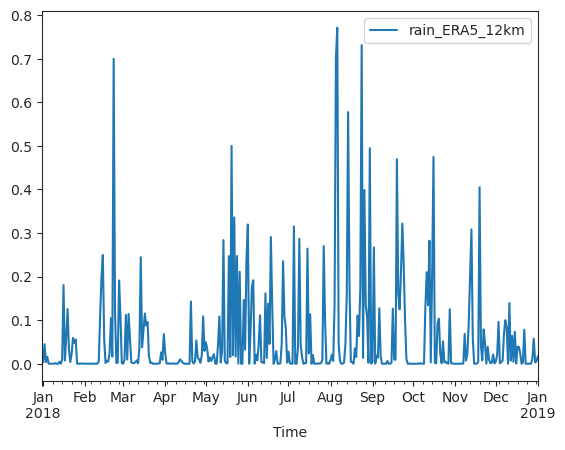

In [ ]:
all_rain.plot()

### add rain from ACIS

In [ ]:
weatherstationframes[teststation][f'{startyear}-01-01':f'{endyear}-12-31']

,Tmax_f,Tmin_F,Tavg_F,precip_in,sd_m,swe,year
2018-01-01,14,-11,1.5,0.00,13,-9999,2018
2018-01-02,22,7,14.5,0.00,13,-9999,2018
2018-01-03,15,-1,7.0,0.01,13,-9999,2018
2018-01-04,14,-3,5.5,0.01,13,-9999,2018
2018-01-05,3,-7,-2.0,0.00,13,-9999,2018
...,...,...,...,...,...,...,...
2018-12-27,6,-12,-3.0,0.00,10,-9999,2018
2018-12-28,-1,-14,-7.5,0.01,10,-9999,2018
2018-12-29,2,-15,-6.5,0.01,10,-9999,2018
2018-12-30,17,-13,2.0,0.00,10,-9999,2018


In [ ]:
precipDF = pd.DataFrame(weatherstationframes[teststation]['precip_in'] * 2.54)
precipDF.replace(-9999* 2.54, np.nan, inplace=True)
precipDF.columns = [teststation]
precipDF[f'{startyear}-01-01':f'{endyear}-12-31']

,FAIRBANKS INTL AP
2018-01-01,0.0000
2018-01-02,0.0000
2018-01-03,0.0254
2018-01-04,0.0254
2018-01-05,0.0000
...,...
2018-12-27,0.0000
2018-12-28,0.0254
2018-12-29,0.0254
2018-12-30,0.0000


(0.0, 1.0)

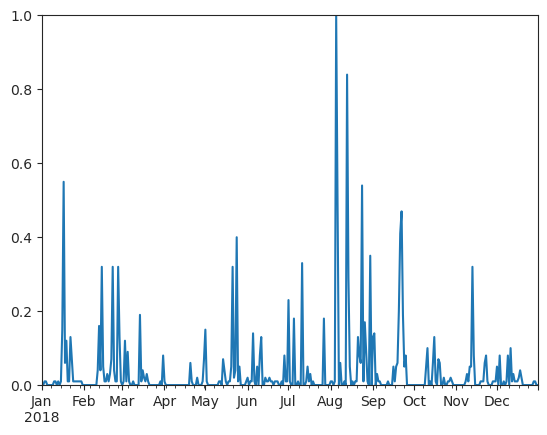

In [ ]:
weatherstationframes[teststation][f'{startyear}-01-01':f'{endyear}-12-31']['precip_in'].plot()
plt.ylim([0, 1])

<Axes: xlabel='Time'>

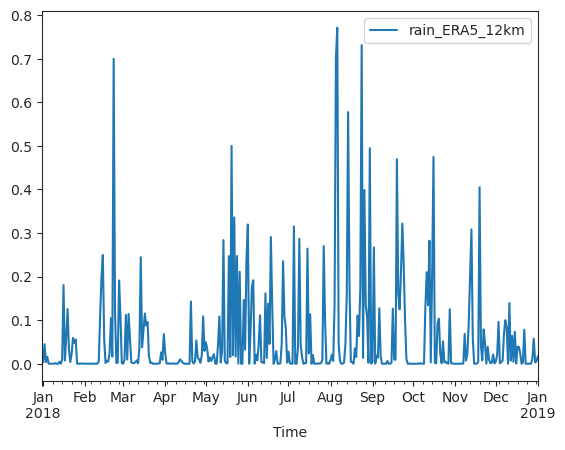

In [ ]:
all_rain.plot()

In [ ]:
compDF = all_rain[1:-1].merge(precipDF[f'{startyear}-01-01':f'{endyear}-12-31'], left_index=True, right_index=True )
compDF

,rain_ERA5_12km,FAIRBANKS INTL AP
Time,,
2018-01-01,0.003091,0.0000
2018-01-02,0.044688,0.0000
2018-01-03,0.003890,0.0254
2018-01-04,0.015965,0.0254
2018-01-05,0.000470,0.0000
...,...,...
2018-12-27,0.000291,0.0000
2018-12-28,0.012462,0.0254
2018-12-29,0.057336,0.0254


In [ ]:
list(map(lambda x: calendar.month_abbr[x], compDF.index.month))

['Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Jan',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Feb',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Mar',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'Apr',
 'May',
 'May',
 'May',
 'May',
 'May',


In [ ]:
compDF['month'] = list(map(lambda x: calendar.month_abbr[x], compDF.index.month))

In [ ]:
compDF

,rain_ERA5_12km,FAIRBANKS INTL AP,month
Time,,,
2018-01-01,0.003091,0.0000,Jan
2018-01-02,0.044688,0.0000,Jan
2018-01-03,0.003890,0.0254,Jan
2018-01-04,0.015965,0.0254,Jan
2018-01-05,0.000470,0.0000,Jan
...,...,...,...
2018-12-27,0.000291,0.0000,Dec
2018-12-28,0.012462,0.0254,Dec
2018-12-29,0.057336,0.0254,Dec


## Scatterplot

In [ ]:
projdir = Path().resolve().parents[0]
datapath = projdir / "evaluation/working"
resolution = 4

In [ ]:
datafp = datapath / f"precip_{teststation.replace(' ', '_')}_1970_2020_{resolution}km.csv"
compDF = pd.read_csv(datafp, index_col=0)
compDF

,precip_mm_ERA5_4km,BETHEL AIRPORT,month
Time,,,
1970-01-01,1.632,0.000,Jan
1970-01-02,0.000,0.254,Jan
1970-01-03,0.013,0.000,Jan
1970-01-04,0.000,0.000,Jan
1970-01-05,0.000,0.000,Jan
...,...,...,...
2020-12-27,3.087,0.254,Dec
2020-12-28,0.618,0.254,Dec
2020-12-29,1.603,0.000,Dec


In [ ]:
sns.set_style('ticks')

In [ ]:
compDF.columns 

Index(['precip_mm_ERA5_4km', 'BETHEL AIRPORT', 'month'], dtype='object')

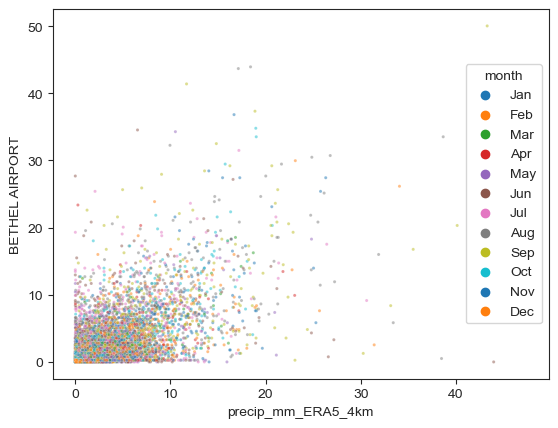

In [ ]:
ax = sns.scatterplot(data=compDF, x=f'precip_mm_ERA5_{resolution}km', y=f'{teststation}', hue='month', alpha=0.5, s=5, palette='tab10')
# ax.set_ylim([0, 10])


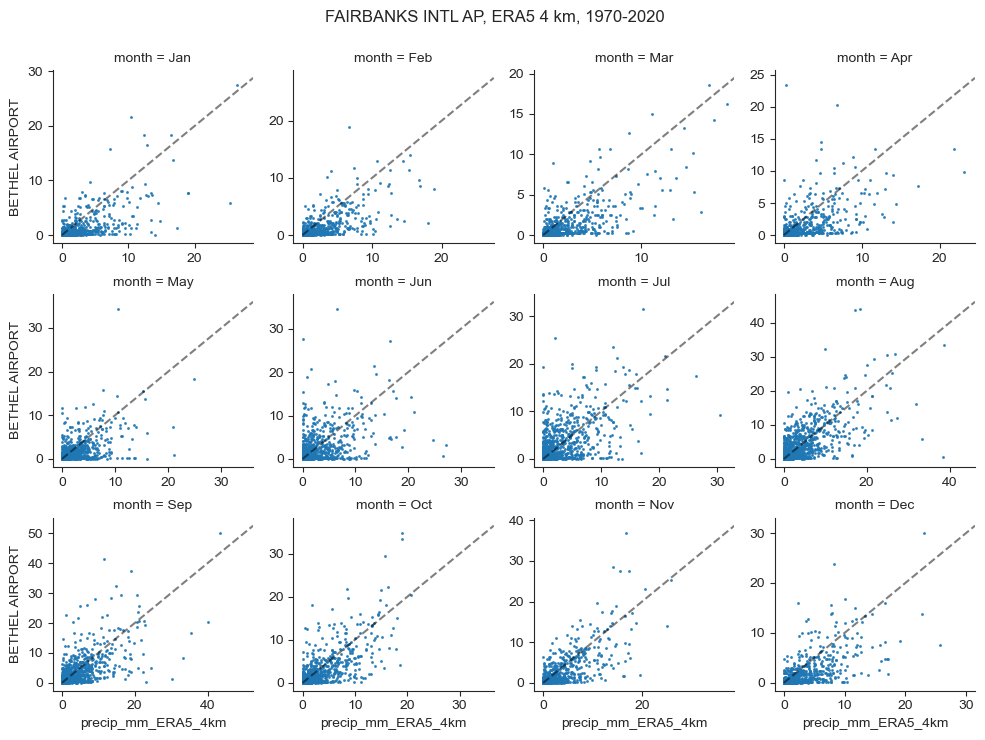

In [ ]:
lm = sns.lmplot(data=compDF, x=f'precip_mm_ERA5_{resolution}km', y=f'{teststation}', col='month', col_wrap=4, 
                fit_reg=False, aspect=1, height=2.5, markers='.', 
           facet_kws=dict(sharex=False, sharey=False),
           scatter_kws={"s": 5})
plt.suptitle(f"{'FAIRBANKS INTL AP'}, ERA5 {resolution} km, 1970-2020\n")
lm.figure.subplots_adjust(top=.9)
axes = lm.axes
for ax in axes:
    ax.set(xlim = ax.get_ylim())
    ax.plot((0, ax.get_xlim()[1]), (0, ax.get_ylim()[1]), c='k', alpha=.5, ls='--')

In [ ]:
ax.get_ylim()

(-1.1938000000000002, 25.0698)

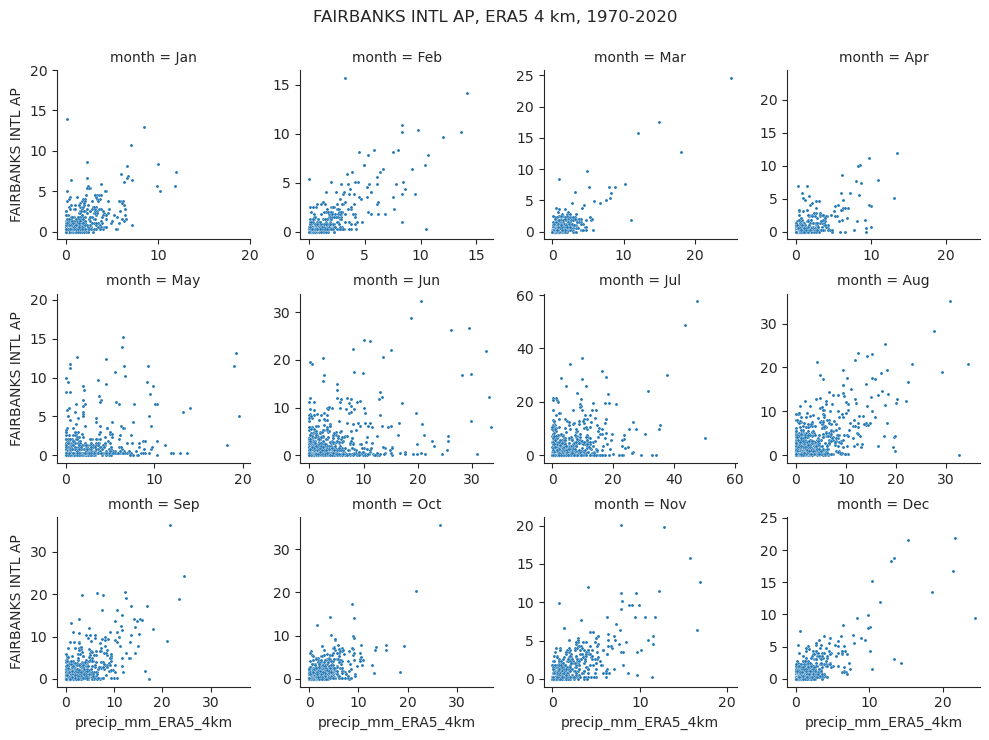

In [ ]:
g = sns.FacetGrid(compDF, col="month", col_wrap=4, sharex=False, sharey=False, aspect=1, height=2.5)
g.map_dataframe(sns.scatterplot, x=f'precip_mm_ERA5_{resolution}km', y='FAIRBANKS INTL AP', s=5, markers='.') 
plt.suptitle(f"{f'{te}'}, ERA5 {resolution} km, 1970-2020\n")
g.figure.subplots_adjust(top=.9)
axes = g.axes
for ax in axes:
    ax.set(xlim = ax.get_ylim())

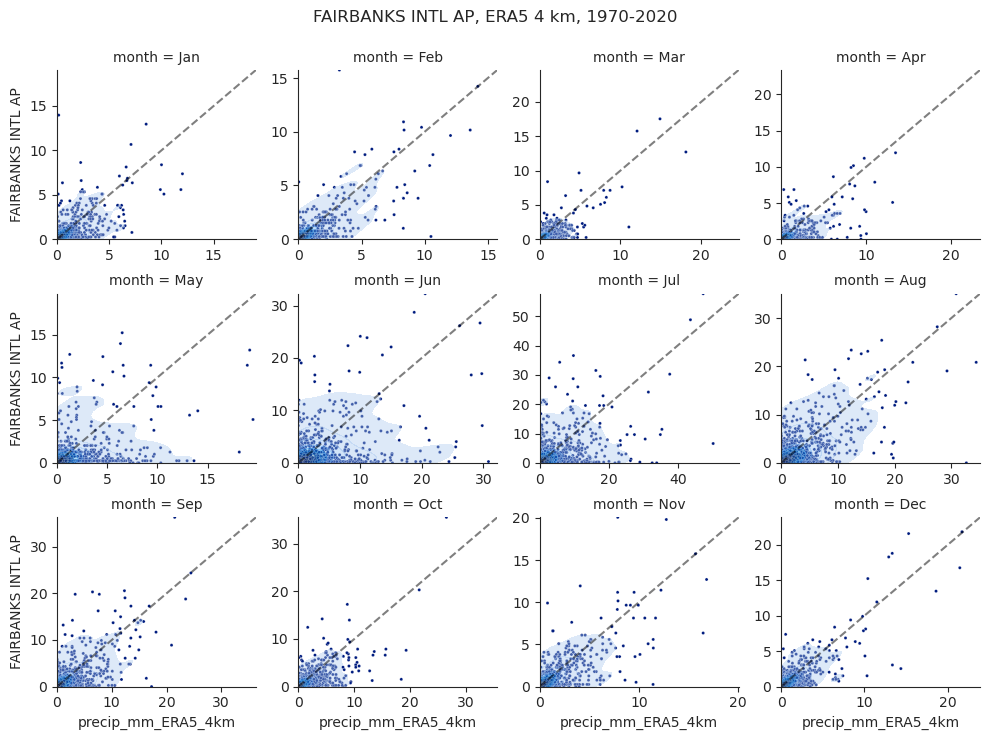

In [ ]:
g = sns.FacetGrid(compDF, col="month", col_wrap=4, sharex=False, sharey=False, aspect=1, height=2.5)
g.map_dataframe(sns.scatterplot, x=f'precip_mm_ERA5_{resolution}km', y='FAIRBANKS INTL AP', 
                s=5, markers='.', hue='month', palette='dark') 
g.map_dataframe(sns.kdeplot, x=f'precip_mm_ERA5_{resolution}km', y='FAIRBANKS INTL AP', 
    fill=True,
    alpha=0.4,
    bw_adjust=1.5,
    cut=0,
    ) 
plt.suptitle(f"{'FAIRBANKS INTL AP'}, ERA5 {resolution} km, 1970-2020\n")
g.figure.subplots_adjust(top=.9)
axes = g.axes
for ax in axes:
    ax.set(xlim = ax.get_ylim())
    ax.plot((0, ax.get_xlim()[1]), (0, ax.get_ylim()[1]), c='k', alpha=.5, ls='--')

In [ ]:
compDF['ERA5_rolling_5'] =  compDF[f'precip_mm_ERA5_{resolution}km'].rolling(window=5).mean()
compDF['Station_rolling_5'] = compDF['FAIRBANKS INTL AP'].rolling(window=5).mean()

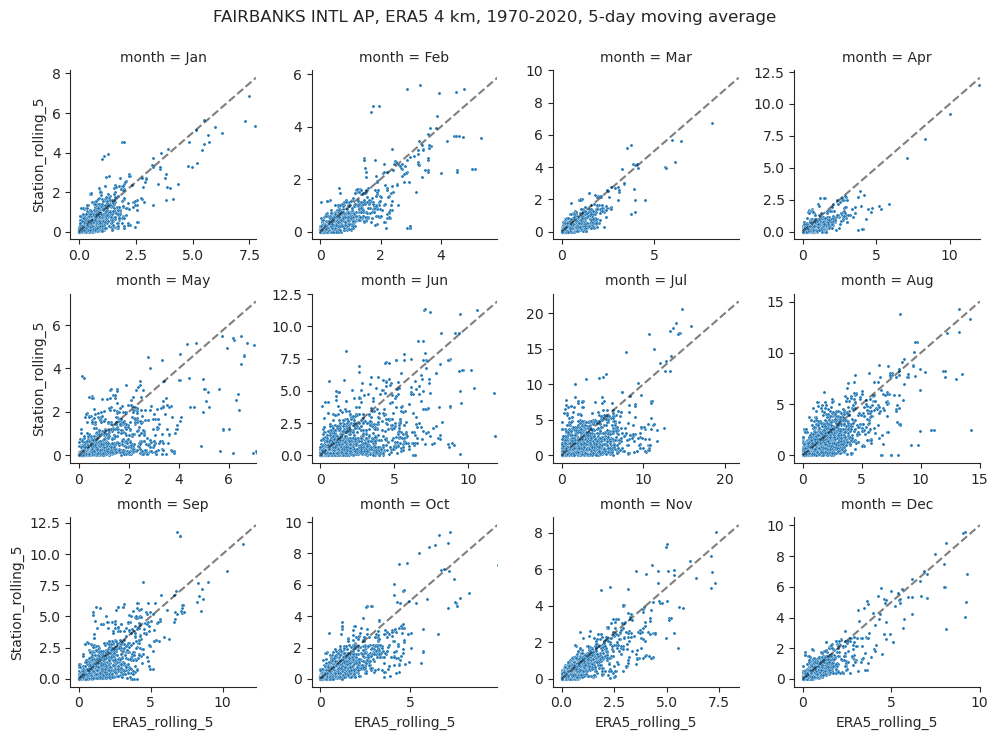

In [ ]:
g = sns.FacetGrid(compDF, col="month", col_wrap=4, sharex=False, sharey=False, aspect=1, height=2.5)
g.map_dataframe(sns.scatterplot, x=f'ERA5_rolling_5', y='Station_rolling_5', s=5, markers='.') 
axes = g.axes
for ax in axes:
    ax.set(xlim = ax.get_ylim())
    ax.plot((0, ax.get_xlim()[1]), (0, ax.get_ylim()[1]), c='k', alpha=.5, ls='--')
plt.suptitle(f"{'FAIRBANKS INTL AP'}, ERA5 {resolution} km, 1970-2020, 5-day moving average\n")
g.figure.subplots_adjust(top=.9)

In [ ]:
sns.set_style("whitegrid")

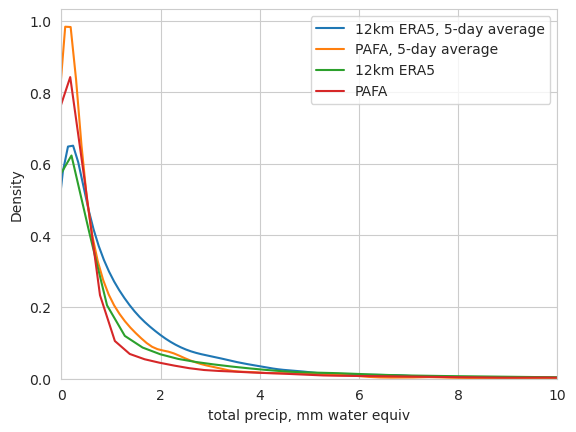

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(compDF['ERA5_rolling_5'], label='12km ERA5, 5-day average')
sns.kdeplot(compDF['Station_rolling_5'], label='PAFA, 5-day average')
sns.kdeplot(compDF['precip_mm_ERA5_12km'], label='12km ERA5')
sns.kdeplot(compDF['FAIRBANKS INTL AP'], label='PAFA')
ax.set_xlim([0, 10])
ax.set_xlabel('total precip, mm water equiv')
ax.legend()

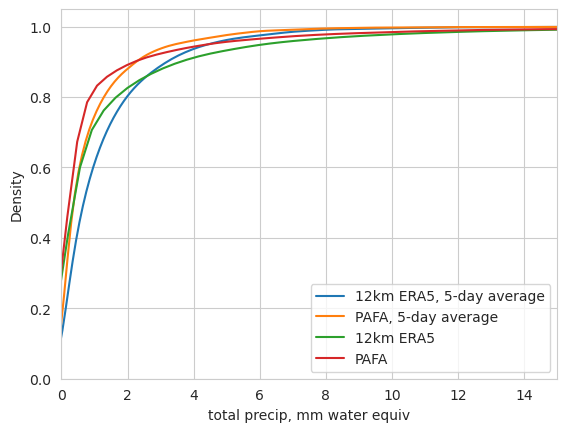

In [ ]:
fig, ax = plt.subplots()
sns.kdeplot(compDF['ERA5_rolling_5'], cumulative=True, label='12km ERA5, 5-day average')
sns.kdeplot(compDF['Station_rolling_5'], cumulative=True, label='PAFA, 5-day average')
sns.kdeplot(compDF['precip_mm_ERA5_12km'], cumulative=True, label='12km ERA5')
sns.kdeplot(compDF['FAIRBANKS INTL AP'], cumulative=True, label='PAFA')
ax.set_xlim([0, 15])
ax.set_xlabel('total precip, mm water equiv')
ax.legend()

AttributeError: 'DataFrame' object has no attribute 'rain'

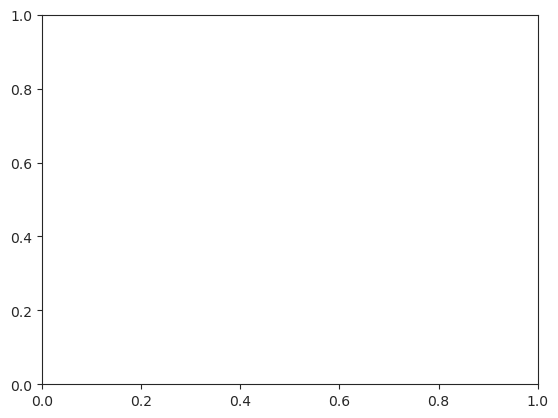

In [ ]:
interval = dt.timedelta(hours=1)     # <----- timedelta of 1 hour

fig, ax = plt.subplots()
ax.bar(all_rain.index, all_rain.rain, width=interval)
fig.autofmt_xdate()

### Comparison w/ NCEI hourly data

In [ ]:
rainDF = pd.read_csv('FAI_PAFA_hourly_precip_NCEI.csv')
rainDF['datetime'] = pd.to_datetime(rainDF.DATE)
rainDF['HPCP'] = rainDF.HPCP.replace(999.99, 0).replace(0.01, 0) * 25.4
rainDF

,STATION,STATION_NAME,DATE,HPCP,datetime
0,COOP:502968,FAIRBANKS INTERNATIONAL AIRPORT AK US,19500101 01:00,0.000,1950-01-01 01:00:00
1,COOP:502968,FAIRBANKS INTERNATIONAL AIRPORT AK US,19500101 11:00,0.762,1950-01-01 11:00:00
2,COOP:502968,FAIRBANKS INTERNATIONAL AIRPORT AK US,19500101 12:00,0.508,1950-01-01 12:00:00
3,COOP:502968,FAIRBANKS INTERNATIONAL AIRPORT AK US,19500101 13:00,0.508,1950-01-01 13:00:00
4,COOP:502968,FAIRBANKS INTERNATIONAL AIRPORT AK US,19500101 14:00,0.762,1950-01-01 14:00:00
...,...,...,...,...,...
42191,COOP:502968,FAIRBANKS INTERNATIONAL AIRPORT AK US,20131001 13:00,0.000,2013-10-01 13:00:00
42192,COOP:502968,FAIRBANKS INTERNATIONAL AIRPORT AK US,20131101 01:00,0.000,2013-11-01 01:00:00
42193,COOP:502968,FAIRBANKS INTERNATIONAL AIRPORT AK US,20131201 00:00,0.000,2013-12-01 00:00:00
42194,COOP:502968,FAIRBANKS INTERNATIONAL AIRPORT AK US,20131201 01:00,0.000,2013-12-01 01:00:00


In [ ]:
dt.datetime.strptime(startdate, '%Y-%m-%d')

datetime.datetime(1967, 7, 1, 0, 0)

In [ ]:
mask = ((rainDF['datetime'] > dt.datetime.strptime(startdate, '%Y-%m-%d')) & 
        (rainDF['datetime'] <= dt.datetime.strptime(enddate, '%Y-%m-%d')))

In [ ]:
bothDF = rainDF.loc[mask].drop(columns=['STATION', 'STATION_NAME', 'DATE']).set_index('datetime').merge(all_rain, how='left', left_index=True, right_index=True)
bothDF.columns = ['COOP:502968', 'ERA5 4 km']

Text(0, 0.5, 'mm')

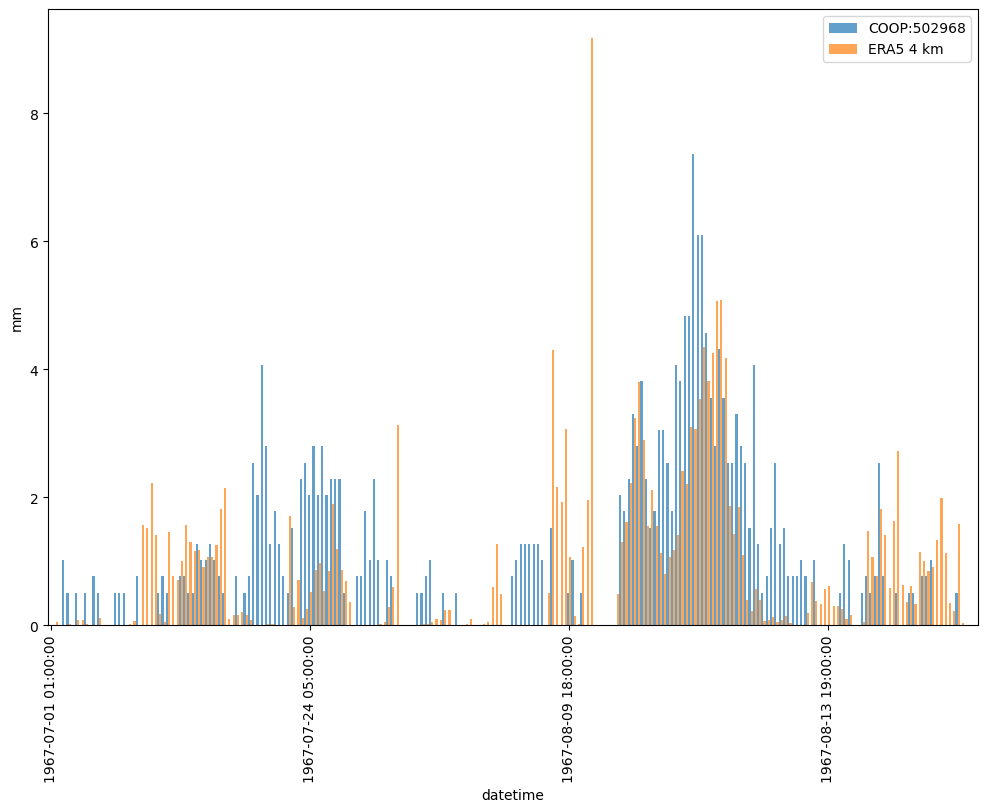

In [ ]:
from matplotlib.ticker import MultipleLocator
fig, ax = plt.subplots(figsize=(12, 8))
bothDF.plot(kind='bar', alpha=0.7, width=1, ax=ax)
ax.xaxis.get_major_locator()                    # <matplotlib.ticker.FixedLocator at 0x2221f657340>
ax.xaxis.get_major_formatter()                  # <matplotlib.ticker.FuncFormatter at 0x2221f8e2a00>

ax.xaxis.set_major_locator(MultipleLocator(60))  # show every 5th tick
plt.ylabel('mm')

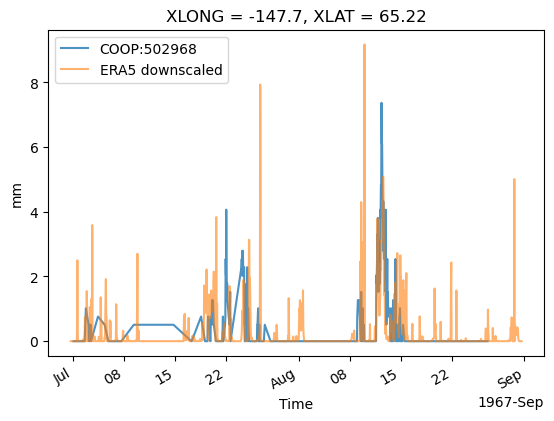

In [ ]:
ax = (rainDF.loc[mask].set_index('datetime').HPCP).plot(label='COOP:502968', alpha=0.8)
xr.concat(concat, dim='Time').plot(ax=ax, alpha=0.6, label='ERA5 downscaled')
plt.ylabel('mm')
plt.legend()

In [ ]:
def getdates(yr):
    return [dateitem.date() for dateitem in pd.date_range(f'{yr}-01-01', f'{yr}-12-31')]

In [ ]:
from math import sqrt
from joblib import Parallel, delayed
import multiprocessing

if __name__ == '__main__':
    test = Parallel(n_jobs=2)(delayed(sqrt)(i ** 2) for i in range(10))
    print(test)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
